# Notes for user:

*   This notebook will use the dataset COVID-19 (positive cases and death rates) and forex to predict the forex spot price of a currency pair.
*   What to ask user before using this application:
*   What currency pair are you interested in? GBP/USD (This layout means that the base currency is USD)
*   The currency the user wants to look at is how much the USD is worth to the GBP.
*   Therefore, we look at the death rates & positive cases in the US.
*   We are looking at dates: 31st Dec 2019 - 31st July 2020.
*   LSTMs are good at looking at changed over time. 


# Part 2: LSTM to prediction Forex Spot Price

# Imports

In [196]:
# Imports
!pip install git+https://github.com/tensorflow/docs
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
#plotting
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
# metrics
import math
# to create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-kufe4l08
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-kufe4l08
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.05c4bd64cc6466af361dfd1f7e19625e7de52fc37_-cp36-none-any.whl size=126759 sha256=844555ad9ef3a75da02c521532aabba16119ef71c2624bcf8173120488fcb52f
  Stored in directory: /tmp/pip-ephem-wheel-cache-sq91at1x/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
2.3.0


In [197]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Data Collection


In [198]:
# Importing covid_dataset using pandas. Droping null values.
covid_dataset_data= pd.read_csv('owid_covid_data.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
# covid_dataset = covid_dataset.dropna()  # We do not want to drop empty tables as this is null values are part of our dataset
covid_dataset.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,0.0,0.0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.0,0.0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.33,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-24,12.0,8.0,0.0,0.0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
3,ABW,North America,Aruba,2020-03-25,17.0,5.0,0.0,0.0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
4,ABW,North America,Aruba,2020-03-26,19.0,2.0,0.0,0.0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [199]:
# Trying to isolate location based on currency in question
us_death_rates = covid_dataset.loc[covid_dataset.location=='United States', ['location', 'date', 'total_cases', 'total_deaths']]
us_death_rates.head()

,location,date,total_cases,total_deaths
32403,United States,2019-12-31,0.0,0.0
32404,United States,2020-01-01,0.0,0.0
32405,United States,2020-01-02,0.0,0.0
32406,United States,2020-01-03,0.0,0.0
32407,United States,2020-01-04,0.0,0.0


In [200]:
# Import forex
forex_dataset_data= pd.read_csv('investing_with_doubles.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
# forex_dataset = forex_dataset_data.dropna()

In [201]:
# Why are these different?
print(us_death_rates.shape), print(forex_dataset.shape)

(218, 4)
(213, 6)


(None, None)

# Data Preprocessing / Data Cleaning & Collating
*   Eliminating columns we dont want
*   Merging tables based on 'Date' column
*   Dates in question: Dec 31 2019 - Jul 31, 2020
*   Once complete we pop the 'date' we merged on 

In [202]:
# Filter dataset
forex_dataset.pop('Open')
forex_dataset.pop('High')
forex_dataset.pop('Low')
forex_dataset.pop('Change %')

0      -0.04%
1       0.76%
2       0.49%
3       0.38%
4       0.72%
        ...  
208     0.62%
209    -0.44%
210    -0.82%
211    -0.05%
212     1.11%
Name: Change %, Length: 213, dtype: object

In [203]:
# Isolate covid_date
import time 
us_date = us_death_rates['date']
new_us_dates = [time.strptime(x.replace("-"," "), '%Y %m %d')for x in us_date]
us_death_rates['date'] = new_us_dates
us_death_rates.head()


,location,date,total_cases,total_deaths
32403,United States,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",0.0,0.0
32404,United States,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",0.0,0.0
32405,United States,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",0.0,0.0
32406,United States,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",0.0,0.0
32407,United States,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)",0.0,0.0


In [204]:
# Isolate forex_date
import time 
forex_date = forex_dataset['Date']
new_forex_dates = [time.strptime(x.replace(',', ""), '%b %d %Y')for x in forex_date]
forex_dataset['Date'] = new_forex_dates
forex_dataset.tail()


,Date,Price
208,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)",1.3169
209,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",1.3088
210,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",1.3146
211,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",1.3255
212,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",1.3261


In [205]:
# Merging dates from two tables
dataset = pd.merge(left=forex_dataset, left_on='Date',
         right=us_death_rates, right_on='date')
dataset.tail()
len(dataset)

213

In [206]:
# We pop the 'date' from the covid_dataset because this column starts later than the forex column
# We want to see the forex price before covid happened
dataset.pop('date')

0       (2020, 7, 31, 0, 0, 0, 4, 213, -1)
1       (2020, 7, 30, 0, 0, 0, 3, 212, -1)
2       (2020, 7, 29, 0, 0, 0, 2, 211, -1)
3       (2020, 7, 28, 0, 0, 0, 1, 210, -1)
4       (2020, 7, 27, 0, 0, 0, 0, 209, -1)
                      ...                 
208        (2020, 1, 4, 0, 0, 0, 5, 4, -1)
209        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
210        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
211        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
212    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
Name: date, Length: 213, dtype: object

In [207]:
dataset.head()

,Date,Price,location,total_cases,total_deaths
0,"(2020, 7, 31, 0, 0, 0, 4, 213, -1)",1.3090,United States,4495014.0,152070.0
1,"(2020, 7, 30, 0, 0, 0, 3, 212, -1)",1.3095,United States,4426982.0,150713.0
2,"(2020, 7, 29, 0, 0, 0, 2, 211, -1)",1.2996,United States,4351997.0,149256.0
3,"(2020, 7, 28, 0, 0, 0, 1, 210, -1)",1.2932,United States,4290263.0,148011.0
4,"(2020, 7, 27, 0, 0, 0, 0, 209, -1)",1.2882,United States,4234020.0,146935.0


# Plotting Features before Normalisation

## Organising date for plotting

In [208]:
# View what date looks like
# Splitting timestamp and isolating the date
date = dataset['Date']
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', '2020-07-31', periods=len(date))})
print(dateFormatting)

                         new_date
0   2019-12-31 00:00:00.000000000
1   2020-01-01 00:06:47.547169811
2   2020-01-02 00:13:35.094339622
3   2020-01-03 00:20:22.641509434
4   2020-01-04 00:27:10.188679245
..                            ...
208 2020-07-26 23:32:49.811320756
209 2020-07-27 23:39:37.358490568
210 2020-07-28 23:46:24.905660380
211 2020-07-29 23:53:12.452830192
212 2020-07-31 00:00:00.000000000

[213 rows x 1 columns]


In [209]:
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()
print(my_xticks)

[Timestamp('2019-12-31 00:00:00'), Timestamp('2020-01-01 00:06:47.547169811'), Timestamp('2020-01-02 00:13:35.094339622'), Timestamp('2020-01-03 00:20:22.641509434'), Timestamp('2020-01-04 00:27:10.188679245'), Timestamp('2020-01-05 00:33:57.735849056'), Timestamp('2020-01-06 00:40:45.283018868'), Timestamp('2020-01-07 00:47:32.830188679'), Timestamp('2020-01-08 00:54:20.377358490'), Timestamp('2020-01-09 01:01:07.924528302'), Timestamp('2020-01-10 01:07:55.471698113'), Timestamp('2020-01-11 01:14:43.018867924'), Timestamp('2020-01-12 01:21:30.566037736'), Timestamp('2020-01-13 01:28:18.113207547'), Timestamp('2020-01-14 01:35:05.660377358'), Timestamp('2020-01-15 01:41:53.207547170'), Timestamp('2020-01-16 01:48:40.754716981'), Timestamp('2020-01-17 01:55:28.301886792'), Timestamp('2020-01-18 02:02:15.849056604'), Timestamp('2020-01-19 02:09:03.396226415'), Timestamp('2020-01-20 02:15:50.943396226'), Timestamp('2020-01-21 02:22:38.490566038'), Timestamp('2020-01-22 02:29:26.037735849'

## Plotting Forex Spot Price

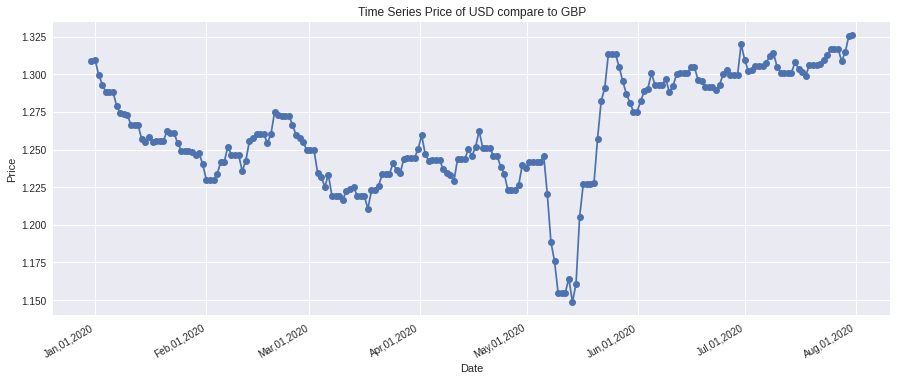

In [210]:
# Plotted prices and dates
# Notice how the dates start and end

rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series Price of USD compare to GBP')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

## Plotting Accumulative Covid Deaths

In [211]:
# Adds the accumulative deaths every day of a country
# Problem – This needs to be sorted from the end since the way out data is set up - can this be made more efficient?
total_us_deaths = dataset['total_deaths']
list_arr = np.array(total_us_deaths)
reversed_arr = list_arr[::-1]
newDayDeaths = 0
dayDeaths = []
for currentday in reversed_arr:
   newDayDeaths = currentday + newDayDeaths
   dayDeaths.append(newDayDeaths)


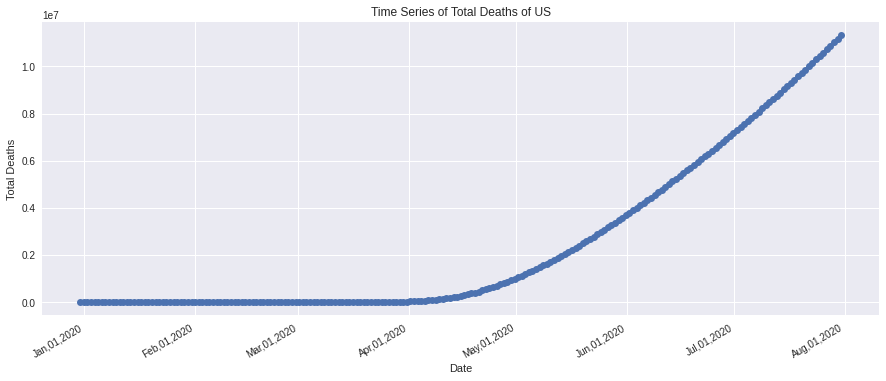

In [212]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
us_deaths = np.array(dayDeaths)
plt.plot_date(dates, us_deaths, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(date_format)



## Plotting Accumulative Positive Cases

In [213]:
# Adds accumulative positive cases everyday
total_us_cases = dataset['total_cases']
list_arr = np.array(total_us_cases)
reversed_arr = list_arr[::-1]
newDayCases = 0
dayCases = []
for currentday in reversed_arr:
   newDayCases = currentday + newDayCases
   dayCases.append(newDayCases)

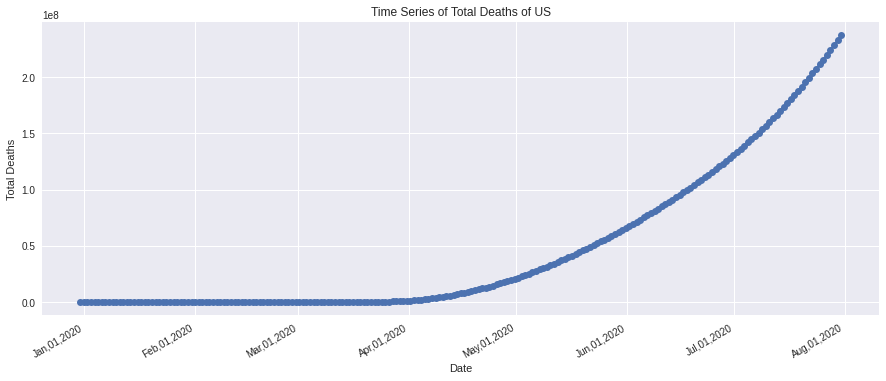

In [214]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
us_cases = np.array(dayCases)
plt.plot_date(dates, us_cases, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(date_format)

# Plotting Feature after Normalisation

In [215]:
price_frame = pd.DataFrame(np.concatenate([price]), columns= ["Price"])
death_frame = pd.DataFrame(np.concatenate([dayDeaths]), columns= ["Total_Deaths_US"])
cases_frame = pd.DataFrame(np.concatenate([dayCases]), columns= ["Total_Cases_US"])
# price_frame.append(death_frame)

In [216]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
normalisation_us_deaths = scaler.fit_transform(death_frame).reshape(-1,1)
normalisation_price = scaler.fit_transform(price_frame).reshape(-1,1)
normalisation_us_cases = scaler.fit_transform(cases_frame).reshape(-1,1)
# 8 decimal: readable formate:
# val = [print("{:.8f}".format(float(x)))for x in normalisation_us_deaths]

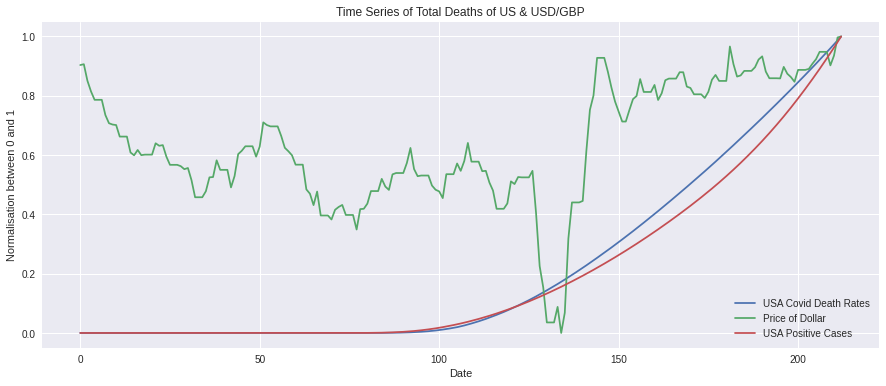

In [217]:
plt.plot(normalisation_us_deaths,label="USA Covid Death Rates")
plt.plot(normalisation_price, label="Price of Dollar")
plt.plot(normalisation_us_cases, label="USA Positive Cases")

# dates
# dates = np.array(dateFormatting['new_date'])
# plt.plot_date(dates, linestyle ='solid')
# plt.gcf().autofmt_xdate()
# date_format = mpl_dates.DateFormatter('%b,%d,%Y')
# plt.gca().xaxis.set_major_formatter(date_format)

plt.title('Time Series of Total Deaths of US & USD/GBP')
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Date')
plt.legend() 
plt.show()


# Splitting Data into Train, Validation & Test


In [218]:
# Creating normalised dataset
# Positive Cases | Death Rates | Price of dollar
new_dataset = np.hstack((normalisation_us_cases, normalisation_us_deaths, normalisation_price))

In [219]:
# Test, Validation, Train 
# This should be ordered in respect to date – not cross validation or random seed
# We are going to divide our data based on date because the next data is always dependent on the previous data
# 65% of the total length of my datadrame
# 35% validation/test size/ 
training_size = int(len(new_dataset)*0.80)
test_size = (len(new_dataset)-training_size)//2 # // Rounds down
train_data, valset_data, test_data = new_dataset[0:training_size], new_dataset[training_size:(training_size + test_size)],new_dataset[(training_size + test_size):]
print(train_data.shape)
print(valset_data.shape)
print(test_data.shape)

(170, 3)
(21, 3)
(22, 3)


In [220]:
# Looking at first 4 days i.e. index 4 does not count
print(valset_data[:4])

[[0.42888805 0.50305516 0.82638106]
 [0.43824254 0.51356645 0.80496054]
 [0.44774091 0.52413131 0.80496054]
 [0.45734791 0.53471876 0.80496054]]


In [221]:
print(training_size, test_size)
print(len(train_data), len(test_data))

170 21
170 22


# X_train, Y_train, X_test, Y_test

In [222]:
# Convert an array of values into a dataset matrix
# time_step = how many previous days you have to consider before making a prediction. = 1 passing by ref
def create_dataset(dataset, time_step=1):
  dataX, dataY = [],[]
  # len(dataset) = 154 - 7 = 147 -1 (guarentees 8th datapoint)
  # for i(starting point of dataset), i in range 146
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step)]  # from i: until i + 7
    dataX.append(a) # then attach it to dataX
    y = dataset[i + time_step][2]  # attach the feature index 2 which is forex of 3 data predictions to y
    dataY.append(y)
  return np.array(dataX), np.array(dataY)


In [223]:
# Weekly_timestep means taking in 7 days of features at a time 
weekly_timestep = 7
X_train, Y_train = create_dataset(train_data, weekly_timestep)
X_val, Y_val = create_dataset(valset_data, weekly_timestep)
X_test, Y_test = create_dataset(test_data, weekly_timestep)



In [224]:
print(X_test.shape), print(Y_test.shape)
# Finished preprocessing the data

(14, 7, 3)
(14,)


(None, None)

# Stacked LSTM Model

In [225]:
# Create the stacked LSTM model

def lstm_model(lr_rate, hidden_layer, optimizer_one):
  # we want input_tensor to be a single data point
  model = Sequential()
  opt = None
  if optimizer_one == 'adam':
   opt = keras.optimizers.Adam(learning_rate=lr_rate)
  elif optimizer_one == 'sgd':
   opt = keras.optimizers.SGD(learning_rate=lr_rate)
  else:
   opt = keras.optimizers.Adamax(learning_rate=lr_rate)
  model.add(InputLayer(input_shape=(7,3)))
  # model.add(LSTM(hidden_layer,return_sequences=True))
  model.add(LSTM(hidden_layer, return_sequences=True))
  model.add(LSTM(hidden_layer))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer=opt)
  return model

  

## Hyperparameter Tuning


*   Optimizers:
[Overview of different Optimizers for neural networks](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3#:~:text=Adagrad%20eliminates%20the%20need%20to,is%20no%20longer%20able%20learning.)
*   [Conceptual Guide for HP Tuning](https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35)
*   [Consider this for Grid Search & Random Search](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html)
*   [And this](https://stackoverflow.com/questions/58137140/randomizedsearchcv-with-keras-lstm-regression)
![Grid Search & Random Search](https://miro.medium.com/max/1200/1*ZTlQm_WRcrNqL-nLnx6GJA.png)



## Grid Search

*   We must choose candidates for good hidden layers and optimizers. Then plot a comparison.
*   List of optimizers: 
*   optimizers = ['SGD', 'RMSprop','adam','adagrad', 'adadelta', 'adamax','nadam', 'ftrl']
*   Callbacks: Restores best weights that is going to give u best model 
*   Consider changing batch size: slower the batch_size better training, because small dataset




In [226]:
hidden_layer_list = [15,30]
best_hidden_layer = 1
optimizer_list = ['adam', 'adamax']
best_optimizer = 'adam'
learning_rate_list = [3e-3,3e-4]
best_learning_rate = 3e-3
least_loss = 1

for each_hidden_layer in hidden_layer_list:
  for each_optimizer in optimizer_list:
    for each_learning_rate in learning_rate_list:
      our_model = lstm_model(each_learning_rate, each_hidden_layer, each_optimizer)
      our_model.fit(X_train, Y_train, 
                validation_data= 
                (X_val, Y_val)
                , epochs=100,batch_size=10,verbose=1,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])
      loss = our_model.evaluate(X_test, Y_test)
      if loss < least_loss:
          least_loss = loss
          best_learning_rate = each_learning_rate
          best_optimizer = each_optimizer
          best_hidden_layer = each_hidden_layer
  print(least_loss, best_learning_rate, best_optimizer, best_hidden_layer)

Epoch 1/100
17/17 [==============================] - 1s 51ms/step - loss: 0.1147 - val_loss: 0.0389
Epoch 2/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0200 - val_loss: 0.0082
Epoch 3/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0139 - val_loss: 9.6683e-04
Epoch 4/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0137 - val_loss: 0.0036
Epoch 5/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0138 - val_loss: 0.0017
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 1/100
17/17 [==============================] - 1s 47ms/step - loss: 0.3109 - val_loss: 0.6482
Epoch 2/100
17/17 [==============================] - 0s 7ms/step - loss: 0.2360 - val_loss: 0.5143
Epoch 3/100
17/17 [==============================] - 0s 7ms/step - loss: 0.1686 - val_loss: 0.3798
Epoch 4/100
17/17 [==============================] - 0s 8ms/step - loss: 0.1072 - val_loss: 0.2483
Epoch 5/100
17/17 [======

# Best Model Prediction

In [227]:
best_param_model = lstm_model(best_learning_rate, best_hidden_layer, best_optimizer)
best_param_model.fit(X_train, Y_train, epochs=160,batch_size=10,verbose=1)
loss = best_param_model.evaluate(X_test, Y_test) # all results from dictionary


Epoch 1/160
17/17 [==============================] - 0s 6ms/step - loss: 0.1199
Epoch 2/160
17/17 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 3/160
17/17 [==============================] - 0s 6ms/step - loss: 0.0135
Epoch 4/160
17/17 [==============================] - 0s 6ms/step - loss: 0.0132
Epoch 5/160
17/17 [==============================] - 0s 6ms/step - loss: 0.0134
Epoch 6/160
17/17 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 7/160
17/17 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 8/160
17/17 [==============================] - 0s 6ms/step - loss: 0.0116
Epoch 9/160
17/17 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 10/160
17/17 [==============================] - 0s 6ms/step - loss: 0.0112
Epoch 11/160
17/17 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 12/160
17/17 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 13/160
17/17 [=================

# Using best model to predict on X_train & X_test

In [228]:
# Prediction and check performance metric
train_predict = best_param_model.predict(X_train)
test_predict = best_param_model.predict(X_test)
train_predict.shape
train_predict.shape

(162, 1)

In [229]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
# print(train_predict, test_predict)

In [230]:
# print(train_predict,test_predict)

# Performance Metric

*   How well is model performing? A measure of what i am predicting and what should have been predicting.
*  **Mean Absolute Error**: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight. 
*   **Mean Squared Error**: Measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.
*   **Kullback-Leibler divergence**, which is also called relative entropy, is a measure of the difference between two probability distributions P and Q where P is the distribution of the observation that we want to see how much it differs from the average prior distribution Q. In statistics, an approximate entropy (ApEn) is a technique used to quantify the amount of regularity and the unpredictability of fluctuations over time-series data.[1]
* [MAE Versus RMSE](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)





In [231]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(Y_train, train_predict))
print(mean_absolute_error(Y_test, test_predict))

133154782.71520732
254110157.9447979


In [232]:
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(Y_train, train_predict)))
print(math.sqrt(mean_squared_error(Y_test, test_predict)))

138943784.19905648
254278364.32548666


In [233]:
# Problem: Y_train, train_predict need to be normalised in order to produce a non negative value?
# Confused on when to normalise and not normalise as I had to transform back for MAE & MSE
# KL Divergence: Probability distribution rather than time series
# Consider this for evaluation: https://www.tensorflow.org/api_docs/python/tf/keras/losses/KLDivergence
# Kl divergence measures difference between 2 probability distributions

def kl_divergence(P,Q):
 epsilon = 0.00001      # Epsilon is used here to avoid conditional code for checking that neither P nor Q is equal to 0.
 P = P+epsilon          #  Made copies to avoid changing the np arrays.
 Q = Q+epsilon
 divergence = np.sum(P*np.log(P/Q))
 return divergence

print(kl_divergence(Y_train, train_predict)) 
print(kl_divergence(Y_test, test_predict))   # Values should be normalized though and they are not currently normalised.


-282564.91323763947
-3476.908690377373


In [234]:
from scipy.stats import entropy
print("\nIndividual Entropy\n")
print(entropy(Y_train))
print(entropy(train_predict))
Y_train_kl = Y_train.reshape(162, 1) # Needed to shape if I wanted to do entropy(_, _)
print("\nPairwise Kullback Leibler divergence\n")
print(entropy(Y_train_kl, qk=train_predict))


Individual Entropy

5.0289937798554565
[5.0347347]

Pairwise Kullback Leibler divergence

[0.0046351]


# Actual Data, Train Prediction & Test Prediction data

(213, 3)
(213, 3)


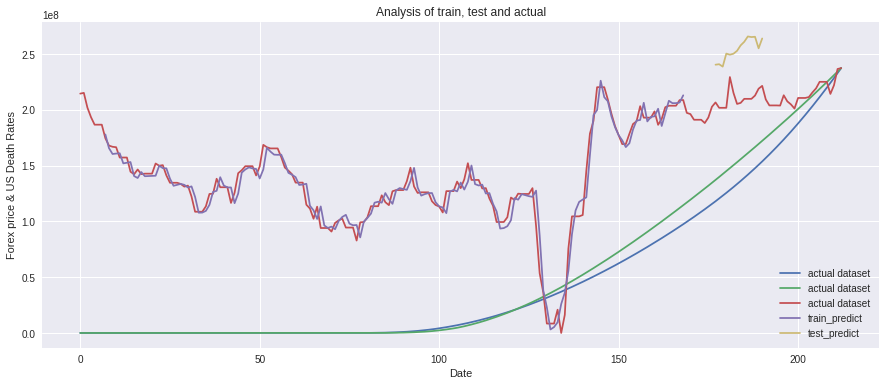

In [235]:
# Problem: testPredictPlot[len(train_predict)+(look_back*2)+2: (training_size + test_size)] = test_predict

# Taking in the 7 

look_back = 7

# empty_like: Return a new array with the same shape and type as a given array.
# np.nan: Replect all with nan? What does this mean?
# What does this do?? 7: predict.length() + 7, :

trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print(trainPredictPlot.shape)

# empty_like: Return a new array with the same shape and type as a given array.
# np.nan: Replect all with nan? What does this mean?
# Dont understand what this is doing
# What does this do?? predict.length() + (7*2) +2 :(training_size + test_size)] = test_predict

testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan

# 
testPredictPlot[len(train_predict)+(look_back*2)+1: (training_size + test_size)] = test_predict
# new_dataset[training_size:(training_size + test_size)]
print(testPredictPlot.shape)

# Plot baseline and predictions
plt.title('Analysis of train, test and actual')
plt.plot(scaler.inverse_transform(new_dataset), label="actual dataset")

trainPredictPlot = [item[2] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict")

testPredictPlot = [item[2] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")

# as you can see th test data and train is divided because we want to test after a specific day
plt.ylabel('Forex price & US Death Rates')
plt.xlabel('Date')
plt.legend()
plt.show()
# Printing 2 actual_dataset, train_predict, test_predict because 2 input layers

# Custom 4 day prediction

*   Training train data to predict future days and evaluating the accuracy on validation data.
*   Training train data to predict future days, no way of evaluating however this can tell us what is likely to occur.
*   Using last 7 days of training data to predict the future custom days(4). 



In [236]:
# Taking the last 7 days of test
# print(test_data[80:])
# is this supposed to be test or train_data
X_input=test_data[100:].reshape(1,-1)
print(X_input)
X_input.shape

temp_input = train_data[-7:]
temp_input



[]


array([[0.36645202, 0.43112686, 0.85231116],
       [0.37508216, 0.44124607, 0.85794814],
       [0.38381989, 0.45143297, 0.85794814],
       [0.39263992, 0.46164599, 0.85794814],
       [0.40154401, 0.47189386, 0.87936866],
       [0.41054795, 0.48221551, 0.87936866],
       [0.41965953, 0.4926037 , 0.83089064]])

In [237]:
# Demonstrate prediction for the next 4 days:

# Step 1. 7 days of feature = temp_input taken from the last 7 days of the training set
# Step 2  i is the day you are on and we want to predict 4 days: 0,1,2,3 (4 days)
# Step 3. Predict the 8th day on each of the 7 days,
# Step 4. Add this new predicted day to the list
# Step 5. Because we are now taking in the last 7 days + the new predicted value, the list is now size 8  
# Step 6. In order to take in 7 days at a time, we shift 1 to the right.
# Step 7. We reassign the X_train to the new 7 days
# Step 8. We predict the 8th day of the 7 days and continue the process
# Step 9. We then add the 8th day to the output list
# Step 10. We keep track of the 4 days by incrementing by i at the end-> i = i+1
# Step 11. Once we have predicted the 4 days, we return the list of 4 day values.

from numpy import array
custom_day = 4
lst_output=[]
n_steps=7
i=0
X_input = temp_input
# print(X_input)
while(i<custom_day):
  if(len(temp_input)>7):
    # print(temp_input)  
    X_input=array(temp_input[1:])
    # print("{} day input {}".format(i,X_input))
    # Correct input shape (1,7,3)
    X_input=X_input.reshape((1,n_steps,3))
    # Prediction of X_input
    print(X_input)
    Y_hat = best_param_model.predict(X_input)
    # print(Y_hat)
    temp_input = np.append(temp_input, Y_hat)
    temp_input=temp_input[1:]
    lst_output.append(Y_hat[0][0])
    i=i+1
  else:
    X_input=X_input.reshape((1,n_steps,3))
    print(X_input)
    Y_hat = best_param_model.predict(X_input, verbose=0)
    # print(Y_hat)
    temp_input = np.append(temp_input, Y_hat)
    lst_output.append(Y_hat[0][0])
    i=i+1
# [0.039997526, 0.035484765, 0.029113937, 0.025276443]
# Print the predicted forex price for the next 4 days 
print(lst_output)

[[[0.36645202 0.43112686 0.85231116]
  [0.37508216 0.44124607 0.85794814]
  [0.38381989 0.45143297 0.85794814]
  [0.39263992 0.46164599 0.85794814]
  [0.40154401 0.47189386 0.87936866]
  [0.41054795 0.48221551 0.87936866]
  [0.41965953 0.4926037  0.83089064]]]
[[[0.43112686 0.85231116 0.37508216]
  [0.44124607 0.85794814 0.38381989]
  [0.45143297 0.85794814 0.39263992]
  [0.46164599 0.85794814 0.40154401]
  [0.47189386 0.87936866 0.41054795]
  [0.48221551 0.87936866 0.41965953]
  [0.4926037  0.83089064 0.83773953]]]
[[[0.85231116 0.37508216 0.44124607]
  [0.85794814 0.38381989 0.45143297]
  [0.85794814 0.39263992 0.46164599]
  [0.85794814 0.40154401 0.47189386]
  [0.87936866 0.41054795 0.48221551]
  [0.87936866 0.41965953 0.4926037 ]
  [0.83089064 0.83773953 1.09859622]]]
[[[0.37508216 0.44124607 0.85794814]
  [0.38381989 0.45143297 0.85794814]
  [0.39263992 0.46164599 0.85794814]
  [0.40154401 0.47189386 0.87936866]
  [0.41054795 0.48221551 0.87936866]
  [0.41965953 0.4926037  0.83089

### Plotting evaluation on graph. Training output versus first 4 days of the validation data.

[0.8377395 1.0985962 1.141884  1.018716 ]
[0.8263810597519718, 0.8049605411499439, 0.8049605411499439, 0.8049605411499439]


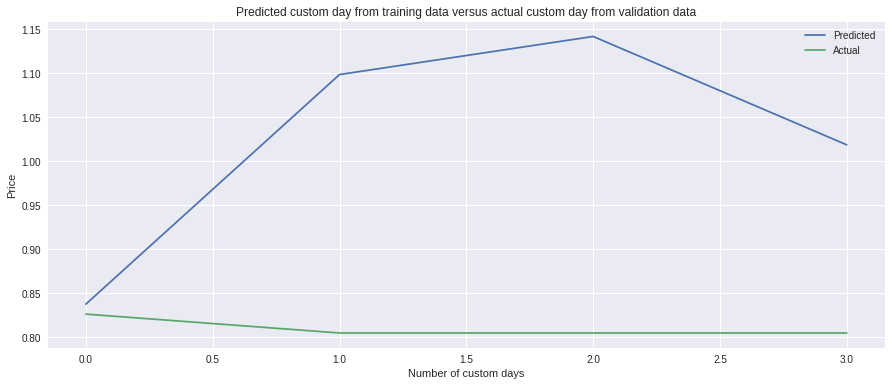

In [238]:
# Custom day plotted
day_new = custom_day-1

# Predicted 4 days from training
# Plot and label
# Transform back to original value before normalised
custom_day_prediction = np.array(lst_output)
print(custom_day_prediction)
plt.plot(custom_day_prediction, label="Predicted")
# plt.plot(day_new, scaler.inverse_transform([custom_day_prediction]))

# Actual 4 days from validation
# Plot and label
# Transform back to original value before normalised
val_data = [item[2] for item in valset_data] 
custom_day_validation = val_data[:custom_day]
print(custom_day_validation)
plt.plot(custom_day_validation, label="Actual")
# plt.plot(day_new, scaler.inverse_transform([custom_day_validation]))

# Information
plt.title('Predicted custom day from training data versus actual custom day from validation data')
plt.xlabel('Number of custom days')
plt.ylabel('Price')
plt.legend()
plt.show()


# Outcome of training test data on best model
* Is this correctly implements? Only difference is X_input
* Strange results
* How can we evaluate? 
* Currently validating against validation data
* What should I be validating it against?

In [239]:
from numpy import array
custom_day = 4
lst_output=[]
n_steps=7
i=0
X_input = X_test
while(i<custom_day):
  if(len(temp_input)>7):
    X_input=array(temp_input[1:])
    X_input=X_input.reshape((1,n_steps,3))
    # Prediction of X_input
    # print(X_input)
    Y_hat = best_param_model.predict(X_input)
    # print(Y_hat)
    temp_input = np.append(temp_input, Y_hat)
    temp_input=temp_input[1:]
    lst_output.append(Y_hat[0][0])
    i=i+1
  else:
    X_input=X_input.reshape((1,n_steps,3))
    # print(Y_hat)
    Y_hat = best_param_model.predict(X_input, verbose=0)
    # print(Y_hat)
    temp_input = np.append(temp_input, Y_hat)
    lst_output.append(Y_hat[0][0])
    i=i+1
# Print the predicted forex price for the next 4 days 
print(lst_output)

[1.1478914, 1.1530855, 1.0079395, 1.1836553]


[1.1478914 1.1530855 1.0079395 1.1836553]
[0.5030551598407069, 0.5135664522526096, 0.5241313106737642, 0.5347187603607648]


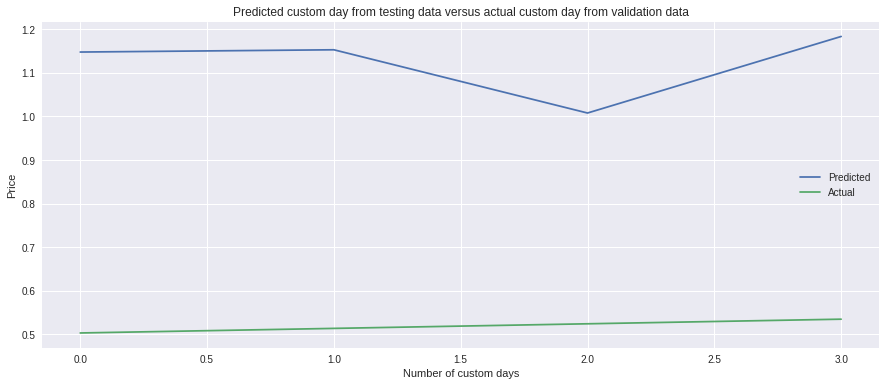

In [240]:
# Need to implement
day_new = custom_day-1

# Predicted 4 days from training
# Plot and label
# Transform back to original value before normalised
custom_day_prediction = np.array(lst_output)
print(custom_day_prediction)
plt.plot(custom_day_prediction, label="Predicted")
# plt.plot(day_new, scaler.inverse_transform([custom_day_prediction]))

# Actual 4 days from validation
# Plot and label
# Transform back to original value before normalised
val_data = [item[1] for item in valset_data] 
custom_day_validation = val_data[:custom_day]
print(custom_day_validation)
plt.plot(custom_day_validation, label="Actual")
# plt.plot(day_new, scaler.inverse_transform([custom_day_validation]))

# Information
plt.title('Predicted custom day from testing data versus actual custom day from validation data')
plt.xlabel('Number of custom days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Conclusion and next steps

After exploring the LSTM algorithm:
*   Notes on working with LSTM & Small Dataset
*   Notes on overfitting

In conclusion it seems that ..